In [2]:
# standard python utilities
import os
from os.path import join, basename,dirname
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
# import rasterio

# mapping utilities
# import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator

# import flopy
# import flopy.utils.binaryfile as bf


In [5]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
    
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = gwfm_dir + '/Oneto_Denier/'
dat_dir = proj_dir+'Stream_level_data/'

fig_dir = proj_dir+'/Streambed_seepage/figures/'
hob_dir = join(gwfm_dir, 'HOB_data')
sfr_dir = gwfm_dir+'/SFR_data/'

py_dir = doc_dir +'GitHub/CosumnesRiverRecharge/python_utilities/'



In [48]:
flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
#     sys.path.append(flopy_dir)
    sys.path.insert(0, flopy_dir)
# sys.path
import flopy 

In [7]:
def gdf_bnds(gdf, ax, buf=1):
    gdf_bnd = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [gdf.unary_union.buffer(buf)], crs=gdf.crs)
    minx, miny, maxx, maxy = gdf_bnd.bounds.values[0]
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    return(gdf_bnd)



In [8]:
def get_layer_from_elev(elev, botm_slice, nlay):
    """  Return uppermost model layer occupied at least partly by some elevation data
    Parameters
    ----------
    elev: 1D array (n) with elevations matching model elevation units
    botm: 2D array (nlay, n) with layer elevations of model using same x,y locations at elev1D
    """
    elev_lay = np.zeros(len(elev))
    for k in np.arange(0,nlay-1):
        for j in np.arange(0,len(elev)):
            if botm_slice[k,j] > elev[j]:
                elev_lay[j] = k + 1
    return(elev_lay.astype(int))

In [414]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'
if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 
loadpth +=  '/GWFlowModel/Cosumnes/Stream_seepage'

model_nam = 'inset_oneto_denier'
# model_nam = 'oneto_denier_homogeneous'

model_ws = join(loadpth,model_nam)

m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
                                exe_name='mf-owhm.exe', version='mfnwt')



In [406]:
print('Quantiles: ',[0,0.5,0.6,0.75,1])
print('HK :',np.quantile(m.upw.hk.array,[0,0.5,0.6,0.75,1]))
print('VKA :',np.quantile(m.upw.vka.array,[0,0.5,0.6,0.75,1]))

Quantiles:  [0, 0.5, 0.6, 0.75, 1]
HK : [48.30783081 48.30783081 48.30783081 48.30783081 48.30783081]
VKA : [0.95765418 0.95765418 0.95765418 0.95765418 0.95765418]


In [10]:
# makes it easier to load if I save a set of outputs with alternate names
m_ver = '' # default no alternate output/input names
# m_ver = '_vka10'


In [11]:
model_grp = 'inset_oneto_denier'
grid_dir = join(gwfm_dir, 'DIS_data/streambed_seepage/grid')
grid_fn = join(grid_dir, model_grp,'rm_only_grid.shp')
grid_p = gpd.read_file(grid_fn)
grid_p.crs='epsg:32610'
m_domain = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_p.unary_union], crs=grid_p.crs)

In [ ]:
lak_shp = join(gwfm_dir,'LAK_data/floodplain_delineation')
lak_extent = gpd.read_file(join(lak_shp,'LCRFR_ModelDom_2017/LCRFR_2DArea_2015.shp' )).to_crs('epsg:32610')


In [12]:
strt_date = pd.to_datetime(m.dis.start_datetime)
# end_date = (strt_date + pd.Series((m.dis.nper-1)*15).astype('timedelta64[m]'))[0] # SS
end_date = (strt_date + pd.Series(m.dis.perlen.array.sum()).astype('timedelta64[D]'))[0]
# with SS period near 0 no longer minus one
dates_per = strt_date + (m.dis.perlen.array.cumsum()).astype('timedelta64[D]')
stplen = m.dis.perlen.array/m.dis.nstp.array
# astype timedelta64 results in save days
dates_stps = strt_date + (np.repeat(stplen, m.dis.nstp.array).cumsum()*24).astype('timedelta64[h]')


In [415]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()

# get ALL stress periods and time steps list, not just those in the output
kstpkper = []
for n,stps in enumerate(m.dis.nstp.array):
    kstpkper += list(zip(np.arange(0,stps),np.full(stps,n)))

dt_ref = pd.DataFrame(dates_stps, columns=['dt'])
dt_ref['kstpkper'] = kstpkper
# dt_ref

In [416]:
sfr = m.sfr
sfrdf = pd.DataFrame(sfr.reach_data)
grid_sfr = grid_p.set_index(['row','column']).loc[list(zip(sfrdf.i+1,sfrdf.j+1))].reset_index(drop=True)
grid_sfr = pd.concat((grid_sfr,sfrdf),axis=1)

# characterize streambed into different hydrofacies
tprogs_quants = np.array([0.590, 0.155, 0.197, 0.058]).cumsum()
# use facies of vka just below stream
vka_sfr = m.upw.vka.array[sfrdf.k, sfrdf.i, sfrdf.j]
vka_quants = pd.DataFrame(np.quantile(vka_sfr, tprogs_quants))
vka_quants.index=['mud','sandy mud','sand','gravel']
grid_sfr['facies'] = 'mud'
for n in np.arange(0,len(vka_quants)-1):
    grid_sfr.loc[vka_sfr > vka_quants.iloc[n].values[0],'facies'] = vka_quants.index[n+1]

## Sensor data and XS data

In [319]:
rm_grid = pd.read_csv(join(proj_dir, 'mw_hob_cleaned.csv'))
rm_grid = gpd.GeoDataFrame(rm_grid, geometry = gpd.points_from_xy(rm_grid.Longitude,rm_grid.Latitude), 
                           crs='epsg:4326').to_crs(grid_p.crs)
# get model layer for heads
hob_row = rm_grid.row.values-1
hob_col = rm_grid.column.values-1

In [320]:
# XS are every 100 m
xs_all = pd.read_csv(dat_dir+'XS_point_elevations.csv',index_col=0)
xs_all = gpd.GeoDataFrame(xs_all,geometry = gpd.points_from_xy(xs_all.Easting,xs_all.Northing), crs='epsg:32610')


In [321]:
XSg = pd.read_csv(join(model_ws,'04_XSg_filled.csv'))
XSg = gpd.GeoDataFrame(XSg, geometry = gpd.points_from_xy(XSg.Easting, XSg.Northing), crs='epsg:32610')

# overwrite SFR segment/reach input relevant to seepage
# sensor_dict = pd.read_csv(join(model_ws, 'sensor_xs_dict.csv'), index_col=0)
# XS_params = sensor_dict.join(params.set_index('Sensor'), on='Sensor')

In [322]:

# correspond XS to sensors
rm_elev = gpd.sjoin_nearest(XSg, rm_grid, how='right',lsuffix='xs', rsuffix='rm')
#MW_11, MW_CP1 had doubles with sjoin_nearest due to XS duplicates from Oneto_Denier
rm_elev = rm_elev.drop_duplicates(['xs_num','Sensor'])

# Plot Groundwater Observed vs Simulated
We need to validate that the local model of Oneto-Denier is adequately representing stream-aquifer interactions so it can be used to quantify storage changes and particle age.

- field data shows fall lows around -2 to 2 m with peaks to 8m with winter
- simulated data shows fall lows around 3-5 meters with peaks to 8 m
- the simulated data as usual isn't showing as extreme reactions as the real data is showing which could be partly due to an issue with the initial steady state levels, the peaks match which means the stream stage is peaking close to reality. I may need to consider adding evapotranspiration as the GDEs are likely pulling water
- adding EVT and RCH together brought the steady state conditions to match observed conditions, but way over-estimated the winter peaks

In [123]:
# hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
# # extract time series of heads for each desired location
# mw_hds = hdobj.get_ts(list(zip(rm_grid['lay'], hob_row, hob_col)))
# mw_hds = pd.DataFrame(mw_hds, columns=['time']+rm_grid.Sensor.tolist())
# # convert to hourly to maintain more precision in DT
# mw_hds['dt'] = strt_date+(mw_hds.time.values*24 ).astype('timedelta64[h]')
# mw_gwl = mw_hds.drop(columns=['time'])
# # long format for id join with observed dat
# mw_long = mw_gwl.melt(id_vars='dt', var_name='Well',value_name='sim')

In [323]:
from sklearn.metrics import r2_score, mean_squared_error

def nse(targets,predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(predictions))**2))


In [417]:
def clean_hob(model_ws):
    hobout = pd.read_csv(join(model_ws,'MF.hob.out'),delimiter=r'\s+', header = 0,names = ['sim_val','obs_val','obs_nam'],
                         dtype = {'sim_val':float,'obs_val':float,'obs_nam':object})
    hobout[['Sensor', 'spd']] = hobout.obs_nam.str.split('p',n=2, expand=True)
    hobout['kstpkper'] = list(zip(np.full(len(hobout),0), hobout.spd.astype(int)))
    hobout = hobout.join(dt_ref.set_index('kstpkper'), on='kstpkper')
    hobout['error'] = hobout.obs_val - hobout.sim_val
    hobout['sq_error'] = hobout.error**2
    return(hobout)


hobout = clean_hob(model_ws)

In [418]:
# summary stats by well
mw_stats = hobout[['Sensor','sq_error']].groupby('Sensor').sum()
mw_stats['r2'] = 0
for s in hobout.Sensor.unique():
    df_s = hobout[hobout.Sensor==s]
    mw_stats.loc[s,'r2'] = r2_score(df_s.obs_val, df_s.sim_val)
    mw_stats.loc[s,'RMSE'] = mean_squared_error(df_s.obs_val, df_s.sim_val, squared=True)
    mw_stats.loc[s,'NSE'] = nse(df_s.obs_val, df_s.sim_val)

t=0
sum_stats = pd.DataFrame(columns=['r2','RMSE','NSE'])
# summary statistics
sum_stats.loc[t,'r2'] = r2_score(hobout.obs_val, hobout.sim_val)
sum_stats.loc[t,'RMSE'] = np.sqrt(hobout.sq_error.sum()/len(hobout))
sum_stats.loc[t,'NSE'] = nse(hobout.obs_val, hobout.sim_val)

sum_stats

,r2,RMSE,NSE
0,-0.1926,2.310144,0.133553


In [419]:
hob_long = hobout.melt(id_vars=['dt', 'Sensor'],value_vars=['sim_val','obs_val'], value_name='gwe', var_name='type')
# hob_long

In [420]:
model_ws

'F:/WRDAPP/GWFlowModel/Cosumnes/Stream_seepage\\inset_oneto_denier'

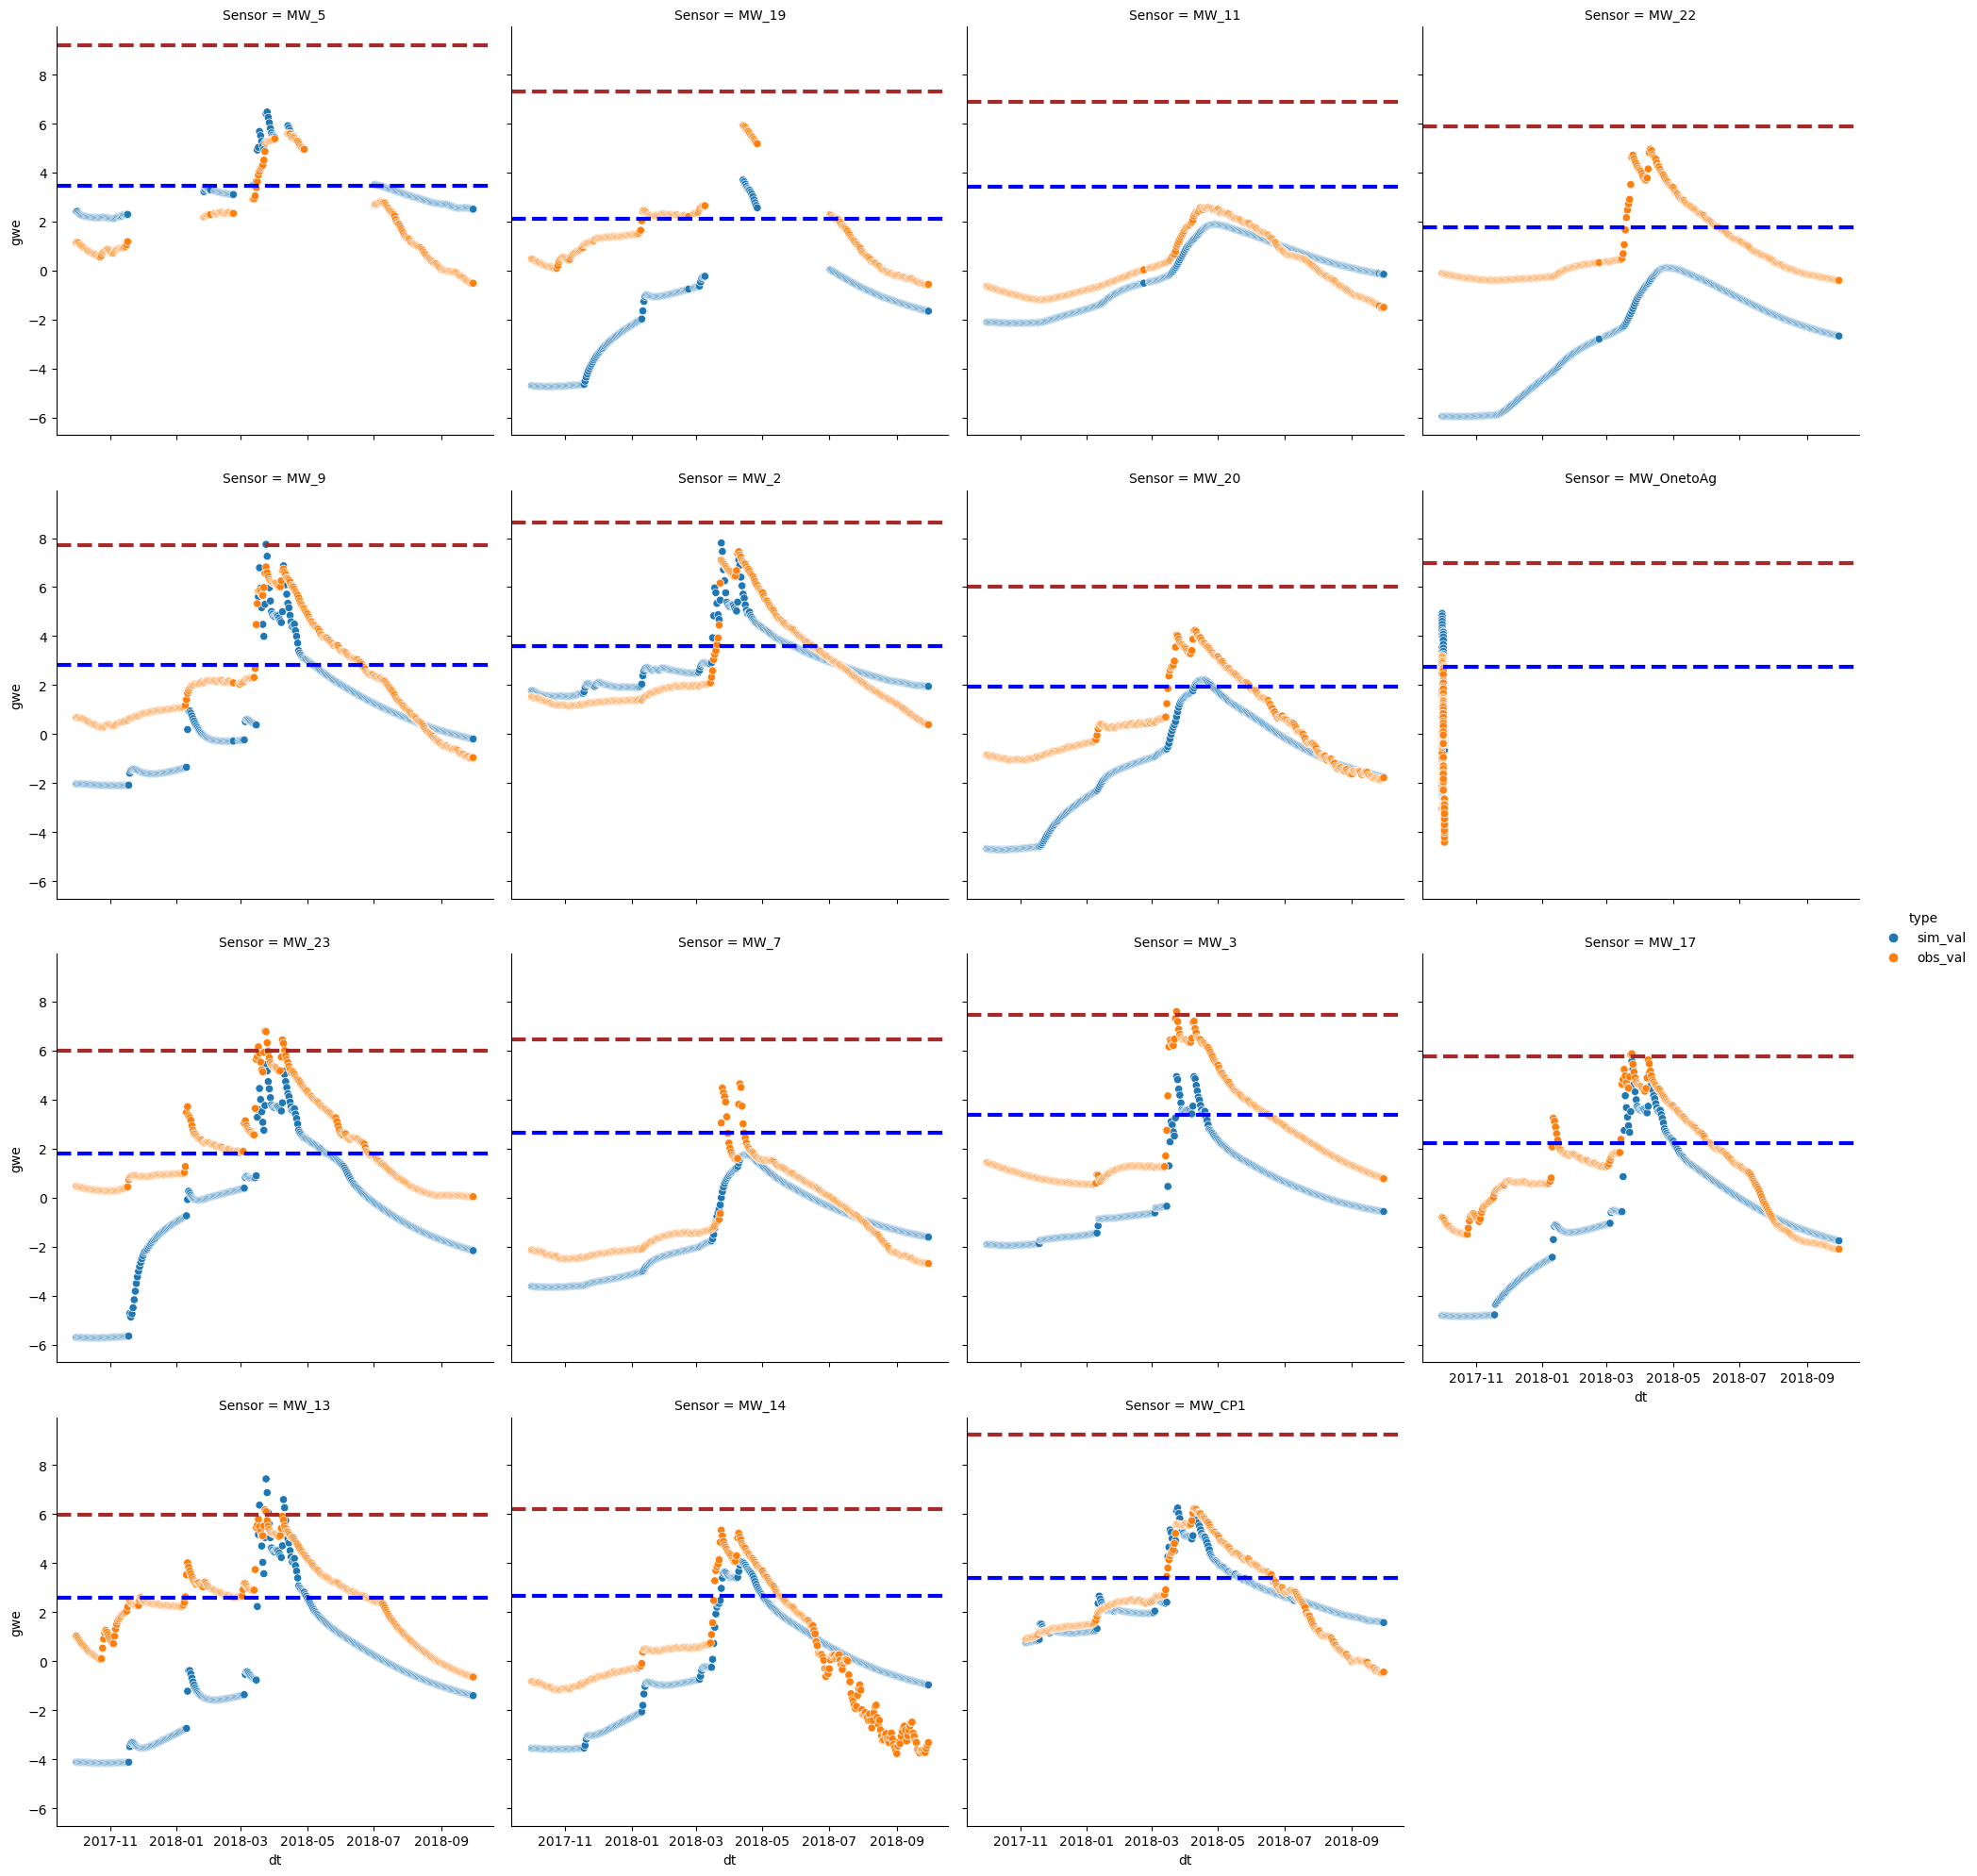

In [421]:
# hob_long, x='dt',y='
g = sns.relplot(hob_long, x='dt',y='gwe',col='Sensor',hue='type', col_wrap=4)

axes = g.axes.flatten()
mw = hob_long.Sensor.unique()

for n in np.arange(0,len(axes)):
    mw_dat = rm_elev[rm_elev.Sensor ==mw[n]]
    axes[n].axhline(mw_dat['MPE (meters)'].values[0], ls='--', linewidth=3, color='brown')
    axes[n].axhline(mw_dat['z_m_min_cln'].values[0]-1, ls='--', linewidth=3, color='blue')

In [427]:
# aggregate error for spatial plotting by month average?

hob_diff = hob_long.pivot_table(index=['dt','Sensor'],values='gwe',columns='type')
hob_diff['h_diff'] = hob_diff.sim_val - hob_diff.obs_val

hob_diff_mon = hob_diff.reset_index().set_index('dt').groupby('Sensor').resample('MS').mean()
hob_diff_mon = hob_diff_mon[['h_diff']].reset_index()
# hob_diff_mon

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_56716\3347723881.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hob_diff_mon = hob_diff.reset_index().set_index('dt').groupby('Sensor').resample('MS').mean()


Text(0.5, 1.0, '2017-11-01')

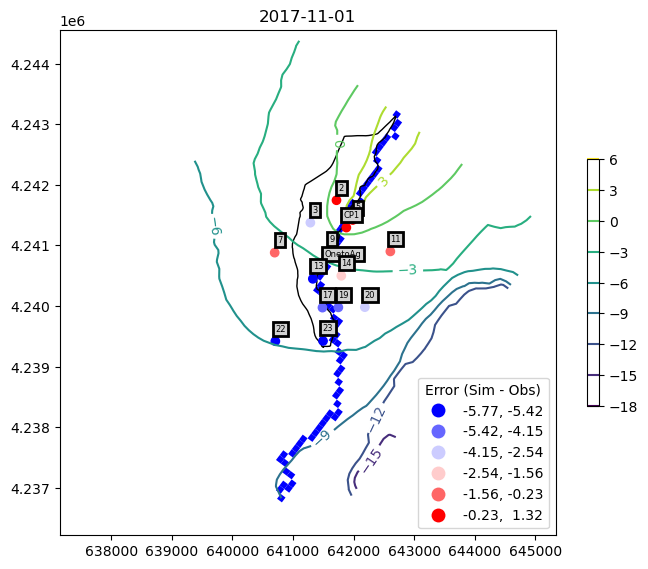

In [446]:
t_plt = '2017-11-01'
# t_plt = '2018-06-01'
# t_plt = '2018-02-01'

diff_plt = hob_diff_mon[hob_diff_mon.dt == t_plt]
# diff_plt['sign'] = np.sign(diff_plt.h_diff)
diff_plt = rm_grid.join(diff_plt.set_index('Sensor'),on='Sensor')

fig,ax=plt.subplots(figsize=(8, 8))
# m_domain.plot(ax=ax,color='None')
mapview = flopy.plot.PlotMapView(model=m,ax=ax)


gdf_bnd = gdf_bnds(rm_grid,buf=400,ax=ax)

# a = m.upw.hk.array
# csa = mapview.plot_array(a[0,:,:], norm=mpl.colors.LogNorm(), alpha=0.6)
# cb = plt.colorbar(csa, shrink=0.75,ax=ax)
# cb.set_label('Horiz. Cond. (m/d)')

spd = dt_ref[dt_ref.dt==t_plt].kstpkper.values[0]
avg_sfr_lay = int(np.round(grid_sfr.k.mean()))
head = hdobj.get_data((0,spd[-1]))[avg_sfr_lay] #m.dis.top.array - 
# m_domain.plot(ax=ax_n,color='none')
im = mapview.contour_array(head, masked_values=[-999.99], ax=ax)
plt.colorbar(im, ax=ax, shrink = 0.4)
plt.clabel(im)

grid_sfr.plot(color='blue', ax=ax)
lak_extent.plot(color='none', ax=ax)
diff_plt.plot('h_diff', scheme='Quantiles', k = 6, ax=ax,
                  legend=True,cmap='bwr', legend_kwds={'loc':'lower right' ,'title':'Error (Sim - Obs)'})

rm_grid.apply(lambda x: ax.annotate(x.Sensor.replace('MW_',''), xy=x.geometry.coords[0], ha='center', fontsize=6,
                                    xytext = (5,10), textcoords='offset pixels',
#                                     arrowprops = {'shrink':1},
                                    bbox=dict(boxstyle="square,pad=0.3", fc="lightgrey", ec="black", lw=2)
                                                        ),axis=1);
ax.set_title(t_plt)

In [32]:
mcc_d = pd.read_csv(sfr_dir+'MCC_flow_obs_all.csv', parse_dates = ['DATE TIME'], index_col='DATE TIME')
mcc_d = mcc_d[(mcc_d.index>strt_date)&(mcc_d.index<end_date)]



In [ ]:
# load local stream stage data

## Lake plotting

In [227]:
# elevSteps, volArray, saArray
bathtxt = np.loadtxt(m.model_ws+'/MF.bath', delimiter = '\t')
bath = pd.DataFrame(bathtxt, columns=['elev','vol','area'])
# bath.plot(x='elev',y='vol')

In [342]:
gage_cols = ['time','stage','volume','conc','inflows','outflows','conductance','error']

def read_gage(gagenam):
    gage = pd.read_csv(gagenam,skiprows=1, delimiter = '\s+', engine='python')
    cols = gage.columns[1:-1]
    gage = gage.dropna(axis=1)
    gage.columns = cols
    strt_date = pd.to_datetime(m.dis.start_datetime)
    gage['dt'] = strt_date+(gage.Time*24).astype('timedelta64[h]')
    gage = gage.set_index('dt')
    gage['dVolume'] = gage.Volume.diff()
    gage['Total_In'] = gage[['Precip.','Runoff','GW-Inflw','SW-Inflw']].sum(axis=1)
    gage['Total_Out'] = gage[['Evap.','Withdrawal','GW-Outflw','SW-Outflw']].sum(axis=1)
    gage['In-Out'] = gage.Total_In - gage.Total_Out
#     gage['name'] = run
    return(gage)
lak_out = read_gage(join(model_ws, 'MF_lak.go'))

<>:4: DeprecationWarning: invalid escape sequence '\s'
<>:4: DeprecationWarning: invalid escape sequence '\s'
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_56716\32272024.py:4: DeprecationWarning: invalid escape sequence '\s'
  gage = pd.read_csv(gagenam,skiprows=1, delimiter = '\s+', engine='python')


In [343]:
# model troubleshooting
# fig,ax = plt.subplots(4,1, sharex=True)
# lak_out.plot(y=['Total_In','Total_Out'], ax=ax[0])
# # plt.yscale('log')
# lak_out.plot(y=['In-Out','dVolume'],ax=ax[1])
# # (lak_out['In-Out']-lak_out.dVolume
# lak_out.plot(y='Volume',ax=ax[2])
# lak_out.plot(y=['Percent-Err'],ax=ax[-1])


<AxesSubplot: xlabel='dt'>

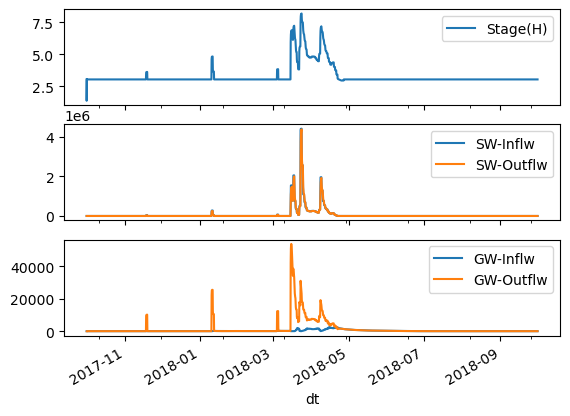

In [344]:
fig,ax = plt.subplots(3,1, sharex=True)
lak_out.plot(y=['Stage(H)'], ax = ax[0]) #dry all the time
# lak_out.columns # GW-Inflw, GW-Outflw, SW-Inflw, SW-Outflw
lak_out.plot(y=['GW-Inflw', 'GW-Outflw'], ax=ax[2]) # there is gw inflow
lak_out.plot(y=['SW-Inflw', 'SW-Outflw'], ax=ax[1]) # there is sw inflow


## SFR Plotting

In [345]:
# grid_sfr = pd.DataFrame().from_records(m.sfr.reach_data).rename(columns={'i':'row','j':'column'})
# grid_sfr[['row','column']] += 1 # convert to 1 based to match with SFR output
pd_sfr = grid_sfr.set_index(['i','j'])[['rchlen','strtop']]
pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()

def clean_sfr_df(model_ws):
    sfrout = flopy.utils.SfrFile(join(model_ws, m.name+m_ver+'.sfr.out'))
    sfrdf = sfrout.get_dataframe()
    sfrdf = sfrdf.join(dt_ref.set_index('kstpkper'), on='kstpkper')
    sfrdf[['row','column']]-=1 # convert to python
    cmd2cfs = 1/((0.3048**3)*86400) # cubic meters per day to cfs

#     sfrdf_plot = pd_sfr.join(sfrdf.set_index(['row','column']),on=['row','column'],how='inner',lsuffix='_all')
    sfrdf_plot = sfrdf.join(pd_sfr ,on=['row','column'],how='inner',lsuffix='_all')
    # dependent on number of time steps
    sfrdf_plot['Qin_cfs'] = sfrdf_plot.Qin * cmd2cfs
    sfrdf_plot['Qout_cfs'] = sfrdf_plot.Qout * cmd2cfs
    sfrdf_plot['Qaquifer_cfs'] = sfrdf_plot.Qaquifer * cmd2cfs
    sfrdf_plot = sfrdf_plot.set_index('dt')
    return(sfrdf_plot)



In [346]:
sfrdf =  clean_sfr_df(model_ws)

In [260]:
sfrdf.columns
# isegs = sfrdf.segment.unique()
quants = sfrdf.Cond.quantile([0.05,0.25,0.5,0.75,0.95])
sfrdf[sfrdf.Cond > quants[0.95]].segment.unique()

array([17, 18, 19, 20, 22, 23, 24, 25, 28, 29, 30, 32, 33, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 48, 49, 68, 69, 70, 71, 72, 73, 74])

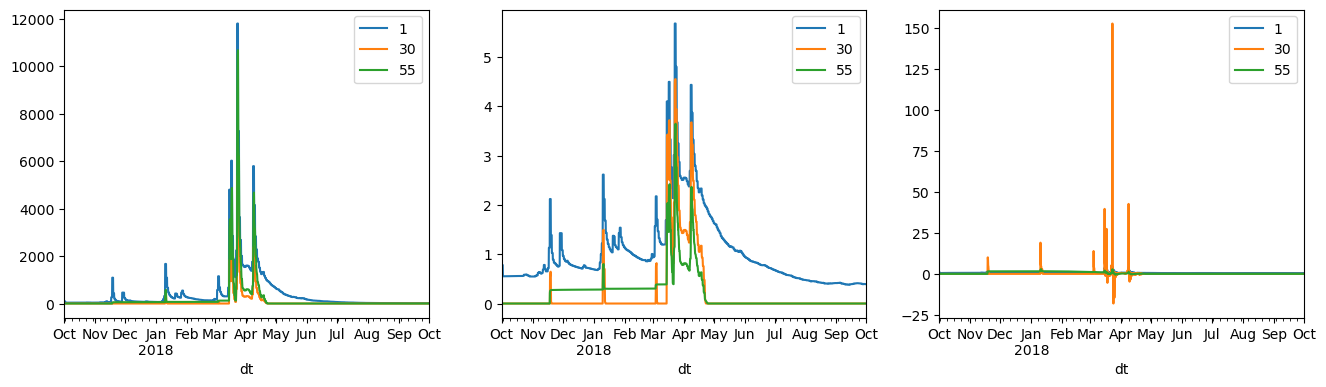

In [347]:
fig, ax = plt.subplots(1,3, figsize=(16,4))
for s in [1,30,55]:
    sfrdf[sfrdf.segment==s].plot(y='Qout_cfs',ax=ax[0], label=s)
    sfrdf[sfrdf.segment==s].plot(y='depth',ax=ax[1], label=s)
    sfrdf[sfrdf.segment==s].plot(y='Qaquifer_cfs',ax=ax[2], label=s)


In [348]:

# far and beyond the stream system is losing
# create different column for stream losing vs gaining seeapge
sfrdf['Qrech'] = np.where(sfrdf.Qaquifer>0, sfrdf.Qaquifer,0)
sfrdf['Qbase'] = np.where(sfrdf.Qaquifer<0, sfrdf.Qaquifer*-1,0 )

sfr_sum = sfrdf.groupby('dt').sum(numeric_only=True)
# sfr_sum.cumsum().plot(y=['Qrech','Qbase'])
# sfr_sum.plot(y=['Qrech','Qbase'])
# plt.yscale('log')
# qaq = sfrdf.groupby('dt').sum(numeric_only=True)['Qaquifer']
# qaq.cumsum().plot(y='Qaquifer') # Qaquifer

In [349]:
# grid_sfr[['iseg','ireach','facies']]
sfr_facies = sfrdf.join(grid_sfr.set_index(['iseg','ireach'])[['facies']], on=['segment','reach'])
sfr_facies_sum = sfr_facies.groupby(['dt','facies']).sum(numeric_only=True)
sfr_facies_sum = sfr_facies_sum[['Qrech','Qbase']].melt(ignore_index=False)



<AxesSubplot: >

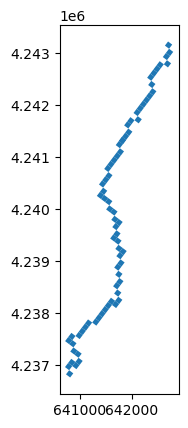

In [350]:
grid_sfr.plot('facies')

The gaining/losing work I did with Stephen Maples shows periods of connection and disconnection and if we assume that the magnitude of stream stage is higher in the wet years then likely the groundwater system is losing in those years as well. What is likely true about floodplains is that the system is predominantly losing except during flood periods when there are more complex local scale gaining/losing conditions. 

What this work shows is that gravels/sands are more active during these extreme wet periods.

<AxesSubplot: xlabel='dt'>

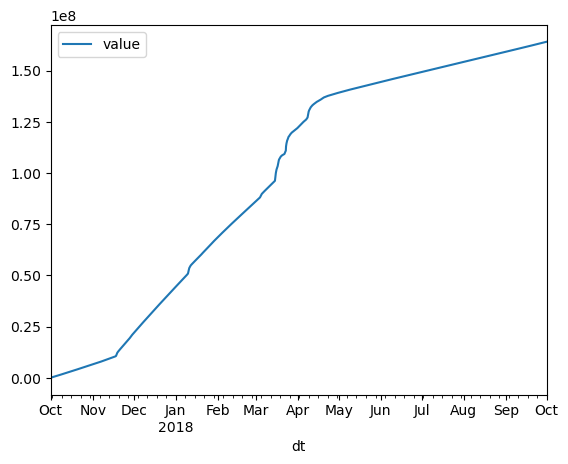

In [351]:
sfr_facies_sum[sfr_facies_sum.variable=='Qrech'].filter(like='mud',axis=0).reset_index('facies').cumsum().plot(y='value')

In [295]:
df_rech= sfr_facies_sum[sfr_facies_sum.variable=='Qrech']
# the mud dataframe has duplicate dates
df_mud = df_rech.filter(like='mud', axis=0).reset_index('facies')
df_sm = df_rech.filter(like='sandy mud', axis=0).reset_index('facies')
df_mud.index, df_sm.index
# df_plt.cumsum().plot(y='value', ax=ax_n, legend=False)
# ax_n.set_title(f)

(DatetimeIndex(['2017-10-01 00:00:00', '2017-10-01 00:00:00',
                '2017-10-01 04:00:00', '2017-10-01 04:00:00',
                '2017-10-01 08:00:00', '2017-10-01 08:00:00',
                '2017-10-01 12:00:00', '2017-10-01 12:00:00',
                '2017-10-01 16:00:00', '2017-10-01 16:00:00',
                ...
                '2018-09-30 08:00:00', '2018-09-30 08:00:00',
                '2018-09-30 12:00:00', '2018-09-30 12:00:00',
                '2018-09-30 16:00:00', '2018-09-30 16:00:00',
                '2018-09-30 20:00:00', '2018-09-30 20:00:00',
                '2018-10-01 00:00:00', '2018-10-01 00:00:00'],
               dtype='datetime64[ns]', name='dt', length=4382, freq=None),
 DatetimeIndex(['2017-10-01 00:00:00', '2017-10-01 04:00:00',
                '2017-10-01 08:00:00', '2017-10-01 12:00:00',
                '2017-10-01 16:00:00', '2017-10-01 20:00:00',
                '2017-10-02 00:00:00', '2017-10-02 04:00:00',
                '2017-10-02 08:00:00

IndexError: index 0 is out of bounds for axis 0 with size 0

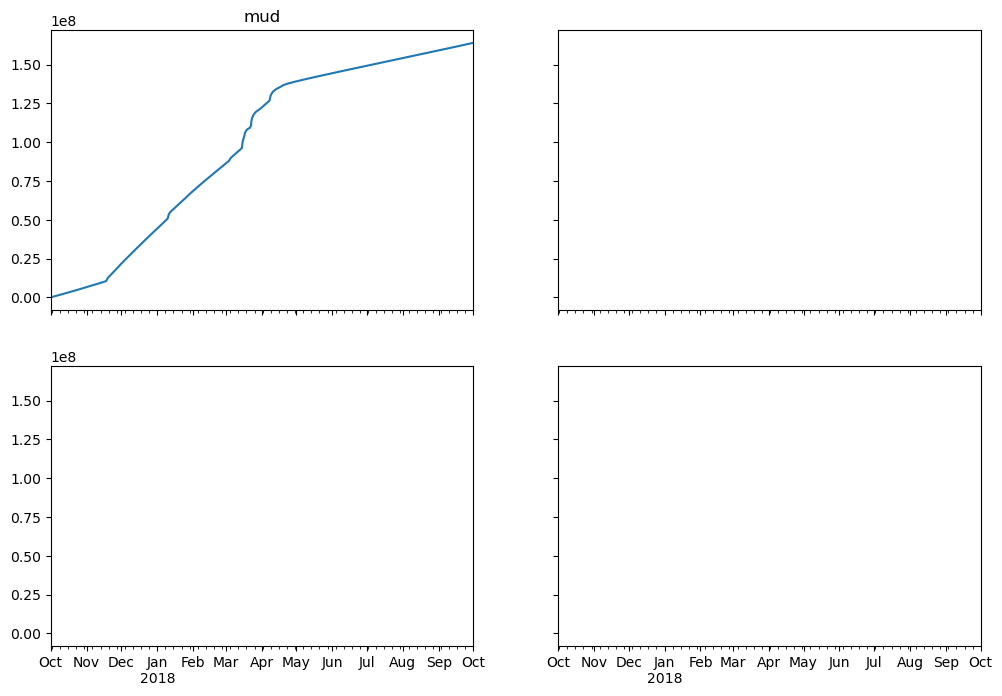

In [352]:
# som eissue with sharex is hiding mud probably issue of dt type, difference between mud and sandy mud
fig,ax = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)#

df_rech= sfr_facies_sum[sfr_facies_sum.variable=='Qrech']
for n, f in enumerate(['mud','sandy mud','sand','gravel']):
    ax_n = ax[int(n/2), n%2]
    df_plt = df_rech.filter(like=f, axis=0).reset_index('facies')
    df_plt.index = pd.to_datetime(df_plt.index)
    df_plt.cumsum().plot(y='value', ax=ax_n, legend=False)
    ax_n.set_title(f)
#     ax_n.set_yscale('log')

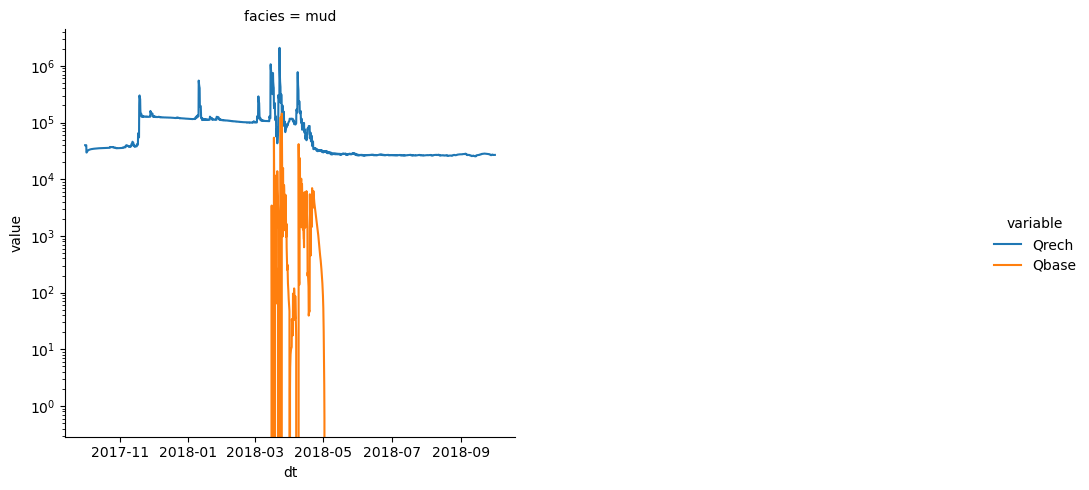

In [353]:
g = sns.relplot(sfr_facies_sum, x='dt',y='value',hue='variable', kind='line',
            col = 'facies', col_wrap=2)
g.set(yscale='log')

In [33]:
# downstream segments increase in number so the issues with large conductance are at the downstream end
# import seaborn as sns
# sns.relplot(sfrdf[sfrdf.Cond > quants[0.95]], x='dt', y='Qout_cfs',col='segment', kind='line', col_wrap=4)

### Plot stream discretization

In [360]:
# hdobj.get_data(t)
# t

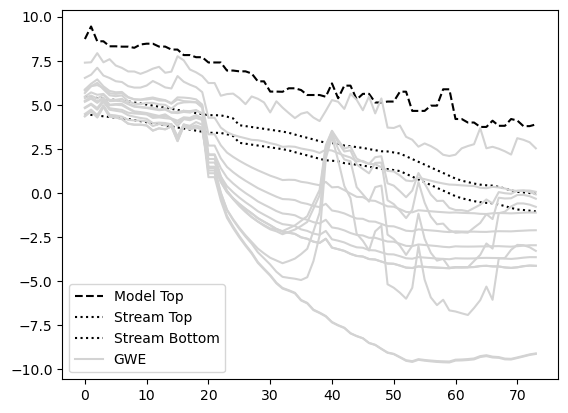

In [359]:
plt.plot(m.dis.top.array[grid_sfr.i, grid_sfr.j], label='Model Top', ls='--',color='black')
plt.plot(m.sfr.reach_data.strtop, label= 'Stream Top', ls=':',color='black')
plt.plot(m.sfr.reach_data.strtop-m.sfr.reach_data.strthick, label= 'Stream Bottom', ls=':',color='black')

# spd_hd = dt_ref[dt_ref.dt == '2020-05-21'].kstpkper.values[0]
# head = hdobj.get_data(spd_hd)[0][0]

for t in spd_stp[0::30]: # every 7 days 
#     spd_hd = dt_ref[dt_ref.dt == t].kstpkper.values[0]
    head = hdobj.get_data(t)[grid_sfr.k, grid_sfr.i, grid_sfr.j]
    head = head[head!=-999.99]
    plt.plot(head, color='lightgray')
plt.plot(head,label = 'GWE',  color='lightgray')

plt.legend()

## Grid wide head distribution

In [35]:
# sfr_gpd = grid_p.set_index(['row','column']).loc[list(zip(grid_sfr.row+1, grid_sfr.column+1))]

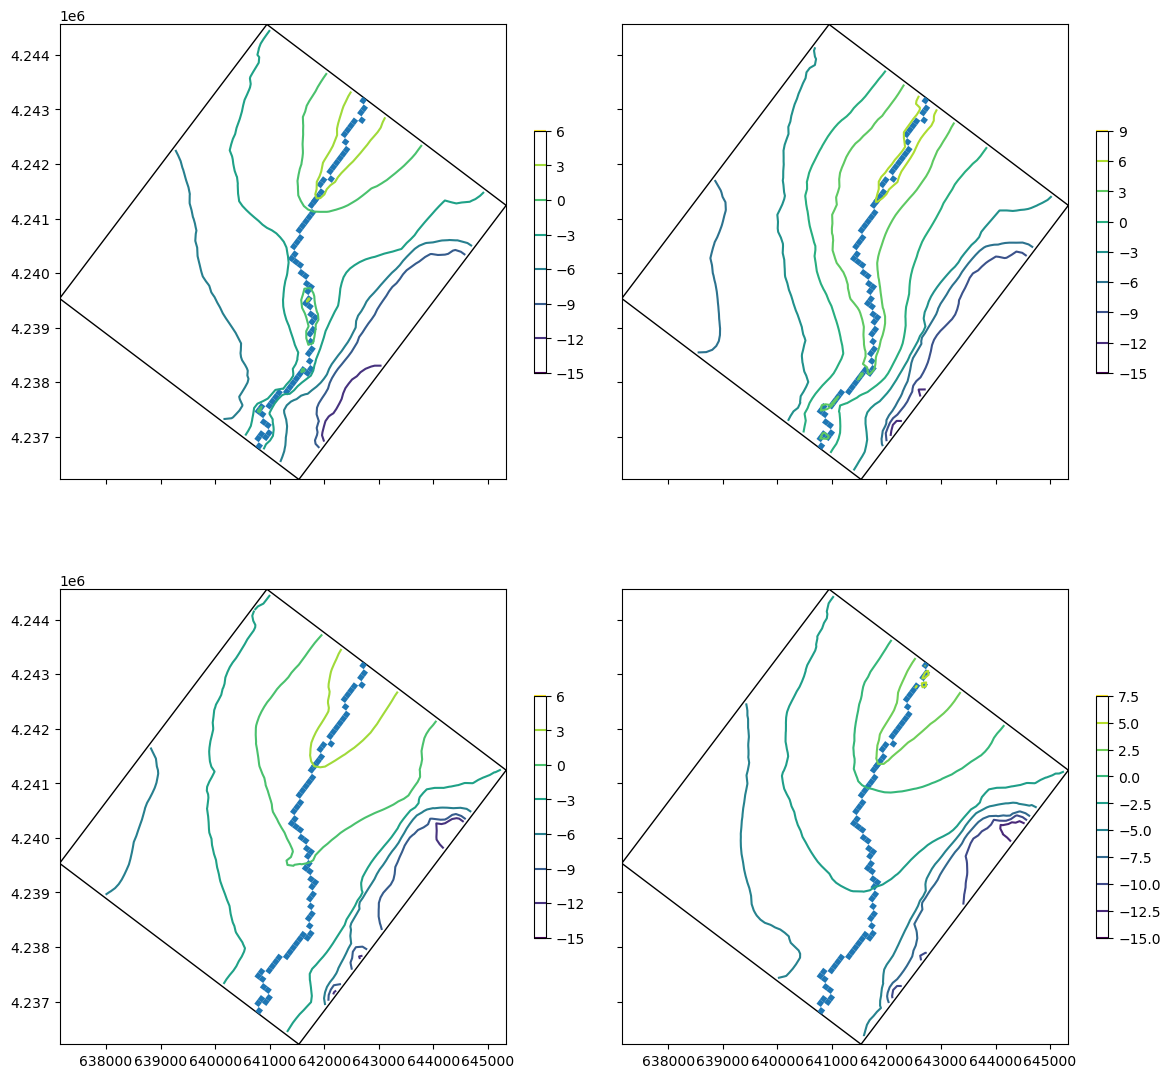

In [430]:
avg_sfr_lay = int(np.round(grid_sfr.k.mean()))

nx = 2
ny = 2
fig,ax = plt.subplots(ny,nx, figsize=(12,12),sharex=True, sharey=True)

# fig.tight_layout()
for n,t in enumerate(spd_stp[::90][1:]):
    head = hdobj.get_data(t)[avg_sfr_lay] #m.dis.top.array - 
        
    ax_n = ax[int(n / ny), n % ny]
    mapview = flopy.plot.PlotMapView(model=m,ax=ax_n)
    m_domain.plot(ax=ax_n,color='none')
    im = mapview.contour_array(head, masked_values=[-999.99], ax=ax_n)
    grid_sfr.plot(ax=ax_n)
# vmin, vmax from visual inspection but could be added with code
#     im = ax_n.contour(head[avg_sfr_lay])

    ax_n.set_aspect(1)
    plt.colorbar(im, ax=ax_n, shrink = 0.4)
# fig.subplots_adjust(wspace=0.2, hspace=-.5)
fig.tight_layout()